# Algumas análises usando Banco de Dados SRAG 2021 incluindo dados da COVID-19
### Neste notebook usaremos apenas os dados de óbitos por COVID-19 do ano de 2021

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#### 'ufs_pop.CSV' contém apenas dados absolutos da população de cada estado, para que se faça uma avaliação no número de óbitos proporcional

In [2]:
pop_data = pd.read_csv('../_data/ufs_pop.CSV',  error_bad_lines=False, encoding = "ISO-8859-1", sep=';')

#### Como o arquivo CSV tem mais de 500MB, abaixo criamos o DataFrame baixando diretamente da fonte.

In [ ]:
df = pd.read_csv('https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2021/INFLUD21-12-07-2021.csv',  error_bad_lines=False, encoding = "ISO-8859-1", sep=';')

#### Como desejamos apenas os dados de COVID, filtramos nosso DataFrame pelos casos diagnosticados ou que o exame tenha dado positivo para PCR_SARS2

In [4]:
df = df[(df['CLASSI_FIN']==5)|(df['PCR_SARS2']==1)]

#### De acordo com o dicionário, código 2 para 'EVOLUCAO' significa óbito

In [5]:
df = df[df['EVOLUCAO']==2]

#### A partir de agora, usaremos apenas as colunas de interesse

In [6]:
cases = df[['SG_UF_NOT', 'DT_EVOLUCA']]

#### Convertendo para objeto tipo datetime

In [7]:
cases["DT_EVOLUCA"] = pd.to_datetime(cases["DT_EVOLUCA"], format='%d/%m/%Y', errors='coerce')

<ipython-input-7-1b6d603c4f17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases["DT_EVOLUCA"] = pd.to_datetime(cases["DT_EVOLUCA"], format='%d/%m/%Y', errors='coerce')


#### Ordenando as datas

In [8]:
cases = cases.sort_values('DT_EVOLUCA')

#### Removendo valores truncados

In [9]:
cases = cases.dropna()

#### Usando pd.get_dummies para converter uma coluna categórica em múltiplas colunas

In [10]:
cases_d = pd.concat([cases.drop('SG_UF_NOT', axis=1), pd.get_dummies(cases['SG_UF_NOT'], columns=pd.unique(cases['SG_UF_NOT']))], axis=1)

#### Agrupando por data para somar todas as ocorrências de óbitos naquele dia

In [11]:
cases_d = cases_d.groupby('DT_EVOLUCA').sum()

#### Mantendo a proporcionalidade dos óbitos

In [12]:
cases_prop = pd.DataFrame()
for uf in cases_d.columns:
    cases_prop[uf] = cases_d[uf] / pop_data.loc[pop_data['SG_UF_NOT'] == uf, 'POP'].values[0]

#### Heatmap não é a melhor opção para visualizar estes dados, mas já dá pra ter uma idéia

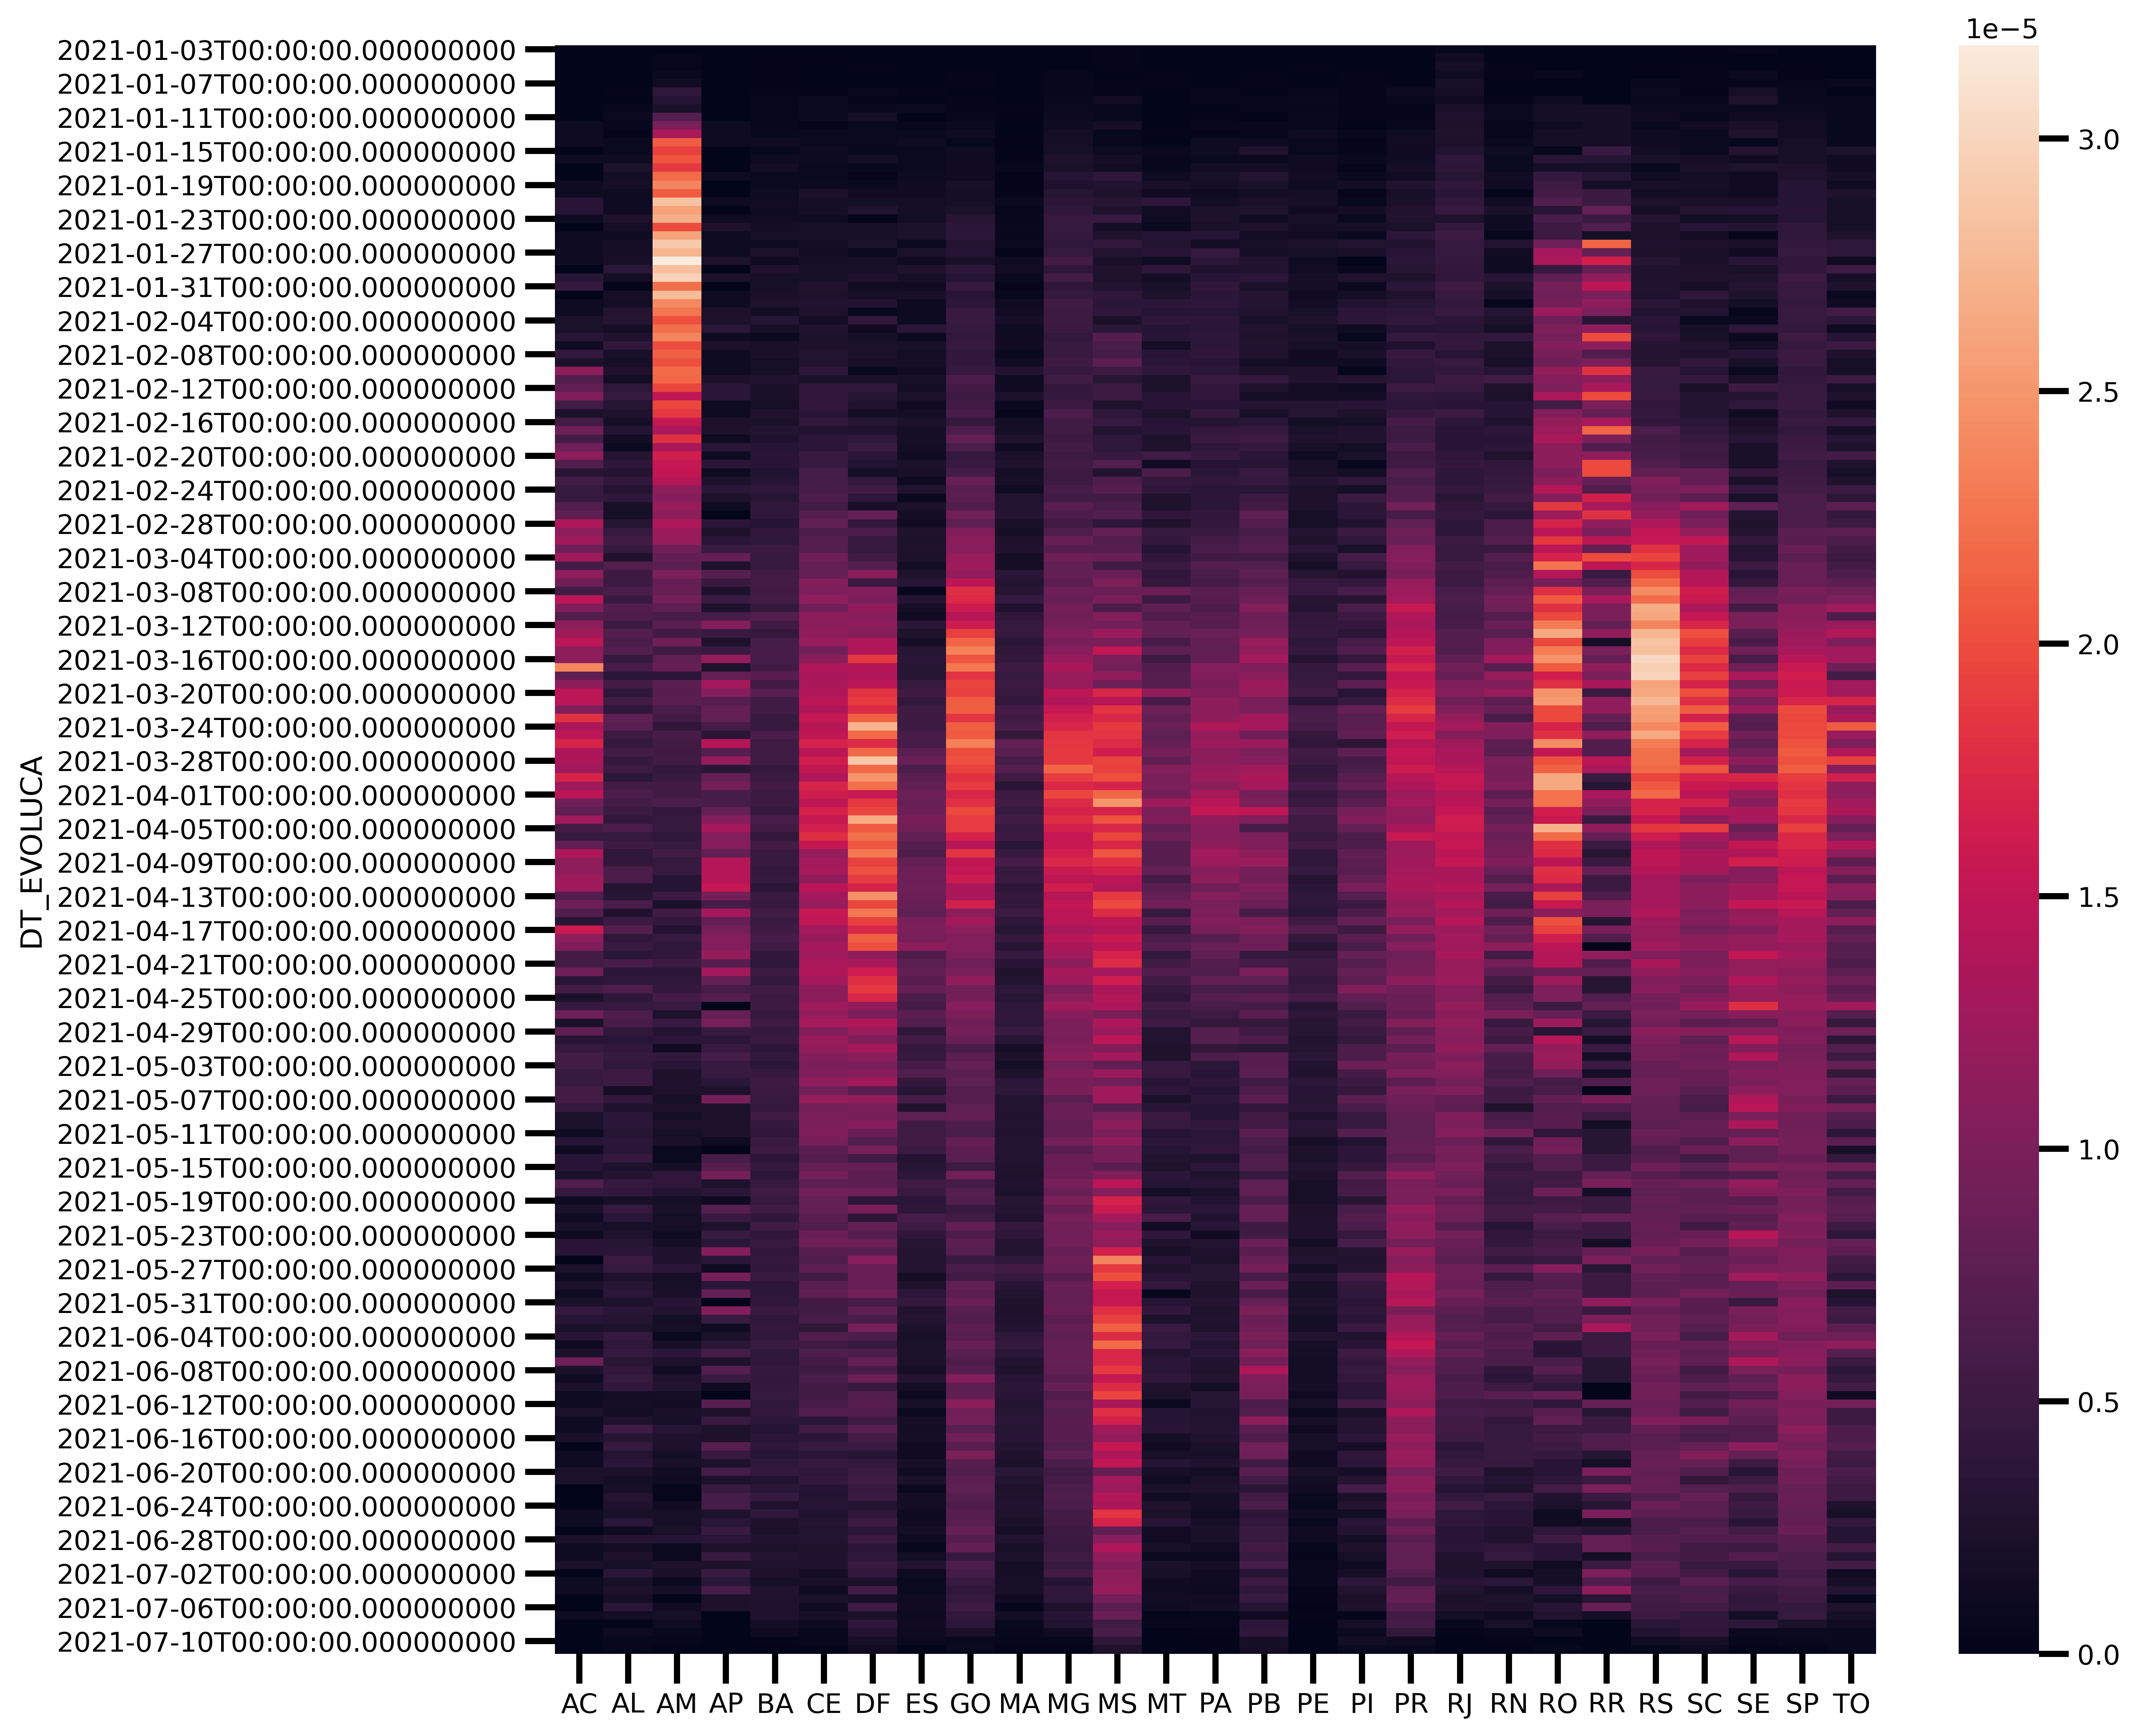

In [13]:
plt.figure(figsize=(12,12), dpi=400)
sns.set_context('poster',font_scale=.5)
sns_plot = sns.heatmap(cases_prop)

#### Neste gráfico de linhas podemos ver melhor as tendências de alguns estados

<AxesSubplot:xlabel='DT_EVOLUCA'>

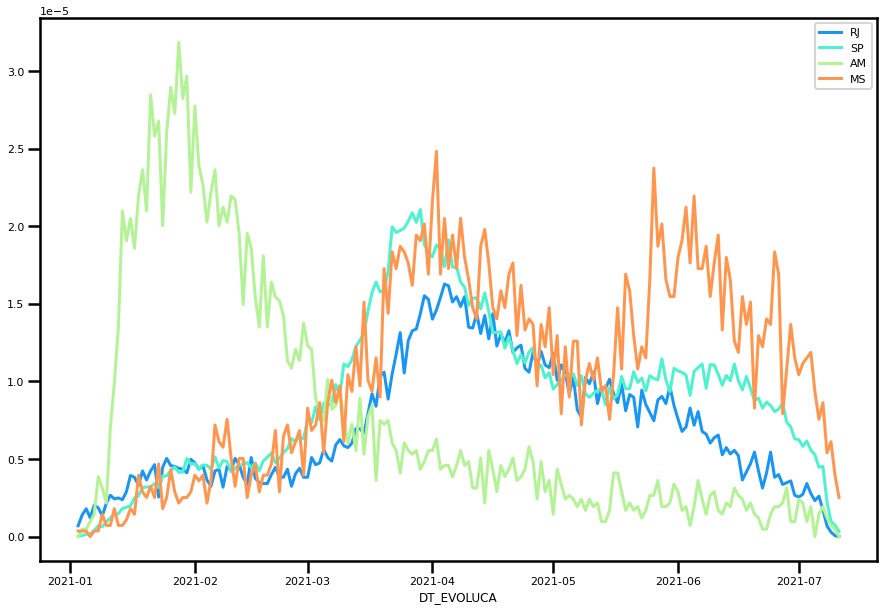

In [14]:
plt.figure(figsize=(15,10))
sns.lineplot(data=cases_prop[['RJ', 'SP', 'AM', 'MS']], dashes=False, palette='rainbow')

#### Eu já tenho escrito um código em outro notebook que trata do atraso nas notificações e devo estar anexando a este em breve.
#### Outra coisa é tratar esses represamento dos dados que faz o gráfico parecer um eletrocardiograma.
#### E fim.